In [36]:
# %pip install catboost

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/Preprocessed_Bank_Customer_Churn_Prediction.csv')

# 사용할 피처 선택 (customer_id 제거)
features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [38]:
# 'balance'와 'estimated_salary' 컬럼을 skewed_columns 리스트에 추가
skewed_columns = ['age']

# log1p 변환 함수
def log1p_transform_columns(df, columns):
    for column in columns:
        df[column] = np.log1p(df[column])  # np.log1p는 log(x+1)
    return df

# log1p 변환 수행
df = log1p_transform_columns(df, skewed_columns)

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,3.761200,2,0.00,1,1,1,101348.88,1
1,608,2,1,3.737670,1,83807.86,1,0,1,112542.58,0
2,502,0,1,3.761200,8,159660.80,3,1,0,113931.57,1
3,699,0,1,3.688879,1,0.00,2,0,0,93826.63,0
4,850,2,1,3.784190,2,125510.82,1,1,1,79084.10,0


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 정규화 (Normalization) - 0과 1 사이로 변환
scaler = MinMaxScaler()

X = df[features]
y = df['churn']

X = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [40]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc

def auc_plot(model:CatBoostClassifier, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

           0     0.8721    0.9644    0.9159      2389
           1     0.7626    0.4468    0.5635       611

    accuracy                         0.8590      3000
   macro avg     0.8173    0.7056    0.7397      3000
weighted avg     0.8498    0.8590    0.8441      3000



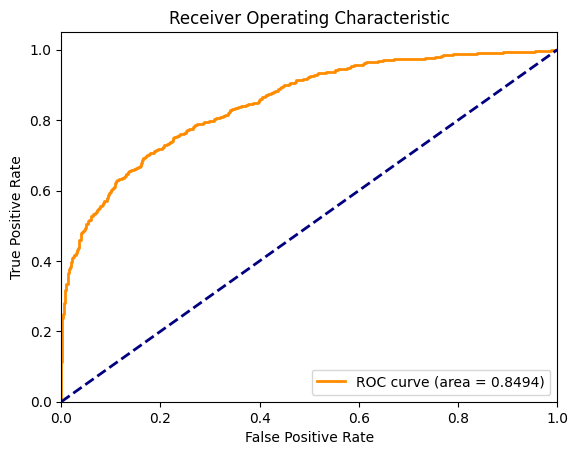

In [41]:
from sklearn.metrics import classification_report
# catboost 모델 적용

# CatBoost 모델 생성
cat = CatBoostClassifier(random_state=42, verbose=0)

# 학습
cat.fit(X_train, y_train, verbose=0)

# 예측
y_pred = cat.predict(X_test)

# 정확도 출력
print(classification_report(y_test, y_pred, digits=4))

auc_plot(cat, X_test, y_test)

In [42]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'depth': [3,4,5],
    'learning_rate': [0.05, 0.1, 0.5],
    'iterations': [50, 100, 150],
}

grid_search = GridSearchCV(estimator=cat, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0, scoring='recall')

grid_search.fit(X_train, y_train, verbose=0)

print('최적의 파라미터 :', grid_search.best_params_)

최적의 파라미터 : {'depth': 5, 'iterations': 100, 'learning_rate': 0.5}


              precision    recall  f1-score   support

           0     0.8724    0.9699    0.9185      2389
           1     0.7907    0.4452    0.5696       611

    accuracy                         0.8630      3000
   macro avg     0.8315    0.7075    0.7441      3000
weighted avg     0.8557    0.8630    0.8475      3000



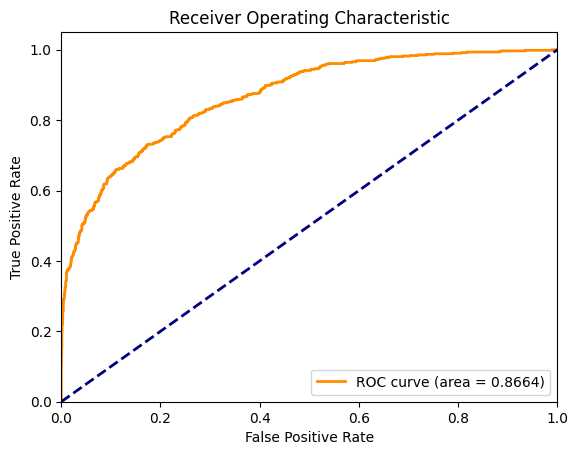

In [43]:
best_params = {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}

cat = CatBoostClassifier(random_state=42, **best_params)

cat.fit(X_train, y_train, verbose=0)

y_pred = cat.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(cat, X_test, y_test)

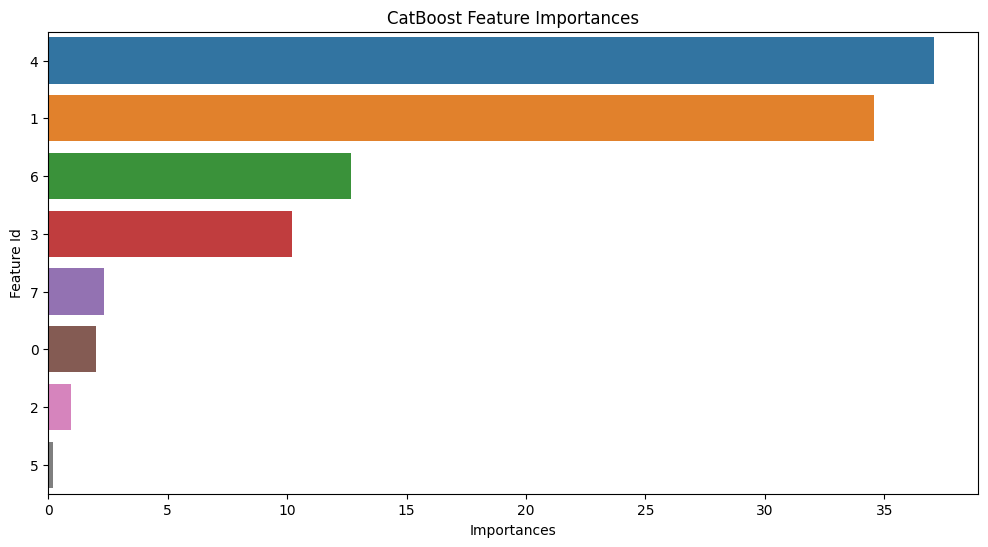

In [44]:
# 피처 중요도 시각화
feature_importance = cat.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importances', y='Feature Id', data=feature_importance, hue='Feature Id', dodge=False)
plt.title('CatBoost Feature Importances')
plt.show()

              precision    recall  f1-score   support

           0     0.9058    0.9021    0.9039      2389
           1     0.6232    0.6334    0.6282       611

    accuracy                         0.8473      3000
   macro avg     0.7645    0.7677    0.7661      3000
weighted avg     0.8483    0.8473    0.8478      3000



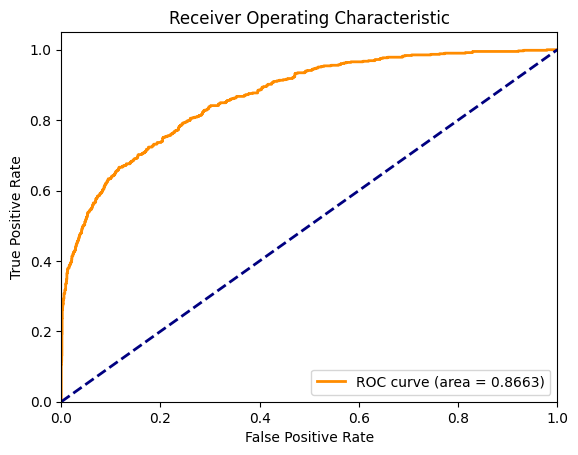

In [45]:
# 가중치 조정
# CatBoost 모델 생성
cat = CatBoostClassifier(random_state=42, verbose=0, class_weights=[1, 2.21], **best_params)
# cat = CatBoostClassifier(random_state=42, verbose=0, class_weights=[1, 50], **best_params)

# 학습
cat.fit(X_train, y_train, verbose=0)

y_pred = cat.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(cat, X_test, y_test)

In [46]:
# export model
cat.save_model('./model/catboost_model.cbm')